In [1]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir("../../")
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/soutrik-vm-dev/code/Users/Soutrik.Chowdhury/langgraph_ventures'

#### P1:Basic Chatbot
Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
import json

from langchain_core.messages import ToolMessage

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [5]:
graph = StateGraph(State)
print(graph)

Our graph can now handle two key tasks:

Each node can receive the current State as input and output an update to the state.\
Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.

In [ ]:
from src.utils import get_llm, get_embedder

llm_model = get_llm()
embedder_model = get_embedder()

In [7]:
# llm_model.invoke("What is the capital of France?")

In [8]:
# embedder_model.embed_query("What is the capital of France?")

In [9]:
# next we add a chatbot node where nodes represent the unit of work

In [10]:
def chatbot(state: State):
    return {"messages": llm_model.invoke(state["messages"])}

In [11]:
graph.add_node("chatbot", chatbot)

Next, add an entry point. This tells our graph where to start its work each time we run it.

In [12]:
graph.add_edge(START, "chatbot")

Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."

In [13]:
graph.add_edge("chatbot", END)

Next we compile the graph

In [14]:
graph_c = graph.compile()

You can visualize the graph using the get_graph method 

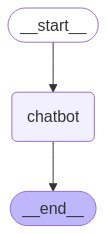

In [15]:
display(Image(graph_c.get_graph().draw_mermaid_png()))

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph_c.stream(
        {"messages": [{"role": "user", "content": user_input}]}
    ):
        for value in event.values():
            print("Assistant:", value["messages"].content)

In [17]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye Exiting...")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today?
Goodbye Exiting...


#### P2: Enhancing the Chatbot with Tools

In [18]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [19]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n[](https://langchain-ai.github.io/langgraph/concepts/low_level/#__codelineno-7-1)fromlangchain_core.runnablesimport RunnableConfig [...] LangGraph Glossary¶\nGraphs¶\nAt its core, LangGraph models agent workflows as graphs. You define the behavior of your agents using three key components:\n\n\nState: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.\n\n\nNodes: Python functions that encode the logic of your agents. They 

In [20]:
llm_with_tools = llm_model.bind_tools(tools)

In [21]:
def chatbot_with_tools(state: State):
    return {"messages": llm_with_tools.invoke(state["messages"])}

WE start with a new Graph

In [22]:
# del graph_builder

In [23]:
# we add state to the graph
graph_builder = StateGraph(State)
# we add the chatbot node
graph_builder.add_node("chatbot", chatbot_with_tools)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls
We will later replace this with LangGraph's prebuilt ToolNode to speed things up

In [24]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [25]:
tool_node = BasicToolNode(tools)
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the conditional_edges.

Recall that edges route the control flow from one node to the next. Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called route_tools, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to tools if tool calls are present and END if not.

Later, we will replace this with the prebuilt tools_condition to be more concise, but implementing it ourselves first makes things more clear.

In [26]:
def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls else return END.
    This basically tells "tools" if the chatbot asks to use a tool, and "END" if it is fine directly responding. This conditional routing defines the main agent loop.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif message := state.get("messages", []):
        ai_message = message[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"

    return END

In [27]:
#  the conditional edge is used to route to the tool node if the last message has tool calls
graph_builder.add_conditional_edges(
    "chatbot", route_tools, {"tools": "tools", END: END}
)

In [28]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

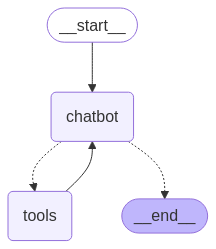

In [29]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
def stream_graph_updates(user_input: str, graph: StateGraph):
    """
    Stream the graph updates for the given user input.
    """
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"])

In [31]:
def execute_graph(graph: StateGraph):
    """
    Execute the graph with the user input and stream the updates.
    """

    while True:
        try:
            user_input = input("User: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye Exiting...")
                break
            stream_graph_updates(user_input, graph)
        except:
            # fallback if input() is not available
            user_input = "What do you know about LangGraph?"
            print("User: " + user_input)
            stream_graph_updates(user_input, graph)
            break

In [32]:
execute_graph(graph)

Goodbye Exiting...


The full code for the graph we've created in this section is reproduced below, replacing our BasicToolNode for the prebuilt `ToolNode`, and our route_tools condition with the prebuilt `tools_condition`

In [33]:
from langgraph.prebuilt import ToolNode, tools_condition

In [34]:
# start by creating a new graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot_with_tools)
# tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
# add consitional edge
graph_builder.add_conditional_edges("chatbot", tools_condition)
# anytime a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# set entrypoint
graph_builder.set_entry_point("chatbot")
# build the graph
graph = graph_builder.compile()

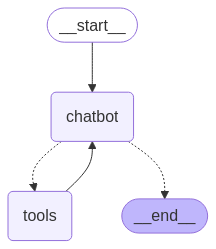

In [35]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
execute_graph(graph)

Assistant: content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 80, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'prot

Persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.

In [37]:
from langgraph.checkpoint.memory import MemorySaver

In [38]:
memory = MemorySaver()

In [39]:
# start by creating a new graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot_with_tools)
# tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
# add consitional edge
graph_builder.add_conditional_edges("chatbot", tools_condition)
# anytime a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# set entrypoint
graph_builder.set_entry_point("chatbot")
# build the graph
graph = graph_builder.compile(checkpointer=memory)

In [40]:
# we set the thread
config = {"configurable": {"thread_id": "1"}}

In [41]:
def stream_graph_updates(user_input: str, graph: StateGraph):
    """
    Stream the graph updates for the given user input.
    """
    # The config is the **second positional argument** to stream() or invoke()!
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    )
    for event in events:
        event["messages"][-1].pretty_print()

In [ ]:
stream_graph_updates("What's a 'node' in LangGraph?", graph)

================================ Human Message =================================

What's a 'node' in LangGraph?


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_3jYrDQMt95n2XTUMsHfQZfxD)
 Call ID: call_3jYrDQMt95n2XTUMsHfQZfxD
  Args:
    query: node in LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "A Comprehensive Guide About Langgraph: Code Included - Ionio", "url": "https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included", "content": "Now let’s take a look at each component of langgraph in detail 🚀\nNodes\nA node can be any function or tool your agent uses in langgraph and these nodes are connected with other nodes using edges. Every workflow ends with a “END” node in langgraph which shows the end of workflow. You also need to define a starting node which will be the starting point of your workflow. Optionally, you can also define an ending node if you know the ending point of your workflow. [...] Workflo

In [ ]:
stream_graph_updates("What's an edge for the same", graph)

================================ Human Message =================================

What's an edge for the same


================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_DAqxYU1LKn5yLWuFy2HOQyLK)
 Call ID: call_DAqxYU1LKn5yLWuFy2HOQyLK
  Args:
    query: edge in LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Advanced LangGraph: Implementing Conditional Edges and Tool ...", "url": "https://dev.to/jamesli/advanced-langgraph-implementing-conditional-edges-and-tool-calling-agents-3pdn", "content": "In the previous articles, we discussed the limitations of LCEL and AgentExecutor, as well as the basic concepts of LangGraph. Today, we will delve into the advanced features of LangGraph, focusing on the use of conditional edges and how to implement a complete tool-calling agent.\nAdvanced Usage of Conditional Edges\nConditional edges are one of the most powerful features in LangGraph, allowing us to dynamically decide the execution flow based on t

Analyze the checkpoint

In [44]:
snapshot = graph.get_state(config)
print(snapshot)

StateSnapshot(values={'messages': [HumanMessage(content="What's a 'node' in LangGraph?", additional_kwargs={}, response_metadata={}, id='2884b897-1172-46a9-9615-cc273a1e3bdc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3jYrDQMt95n2XTUMsHfQZfxD', 'function': {'arguments': '{"query":"node in LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 88, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False,

In [45]:
snapshot.values

{'messages': [HumanMessage(content="What's a 'node' in LangGraph?", additional_kwargs={}, response_metadata={}, id='2884b897-1172-46a9-9615-cc273a1e3bdc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3jYrDQMt95n2XTUMsHfQZfxD', 'function': {'arguments': '{"query":"node in LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 88, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'

After analysis what we see is :
- First is the Human message
- Sesond is the llm message for the tool call
- Third is the Tool message
- Fourth is the llm message for the final response


In [46]:
# The snapshot above contains the current state values, corresponding config, and the next node to process. In our case, the graph has reached an END state, so next is empty.

snapshot.next

()

##### Part 4: Human-in-the-loop

LangGraph's persistence layer supports human-in-the-loop workflows, allowing execution to pause and resume based on user feedback. The primary interface to this functionality is the interrupt function. Calling interrupt inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a Command

In [48]:
from langchain_core.tools import tool
from langgraph.types import Command, interrupt

In [49]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [51]:
graph_builder = StateGraph(state_schema=State)

In [53]:
@tool
def human_assistance(query: str) -> str:
    """Request human assistance for a query and return the response."""
    human_response = interrupt({"query": query})
    return human_response["data"]

In [54]:
tavily = TavilySearchResults(max_results=2)
tools = [tavily, human_assistance]

In [56]:
llm_with_tools = llm_model.bind_tools(tools, parallel_tool_calls=False)

In [58]:
tool_node = ToolNode(tools=tools)

In [57]:
def chatbot(state: State):
    messages = llm_with_tools.invoke(state["messages"])
    assert len(messages.tool_calls) <= 1
    return {"messages": [messages]}

In [59]:
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

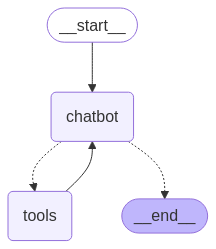

In [60]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
config = {"configurable": {"thread_id": "1"}}

In [62]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"

In [63]:
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

In [64]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_LiZMtGWg1KqIDLF9oAaqjZDs)
 Call ID: call_LiZMtGWg1KqIDLF9oAaqjZDs
  Args:
    query: I need expert guidance for building an AI agent.


In [65]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

To resume execution, we pass a Command object containing data expected by the tool. The format of this data can be customized based on our needs. Here, we just need a dict with a key "data":

In [66]:
human_message = " We are expert in AI agent building. We recommend LangGraph for your needs. Please check it out."

In [67]:
human_command = Command(resume={"data": human_message})

In [68]:
events = graph.stream(human_command, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_LiZMtGWg1KqIDLF9oAaqjZDs)
 Call ID: call_LiZMtGWg1KqIDLF9oAaqjZDs
  Args:
    query: I need expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

 We are expert in AI agent building. We recommend LangGraph for your needs. Please check it out.
================================== Ai Message ==================================

For expert guidance on building an AI agent, it is recommended to check out LangGraph. It is a resource that can help you with your needs.


Part 5: Customizing State

you can add additional fields to the state other than the default message history. This is useful for storing information that is not part of the conversation but is still relevant to the task at hand. For example, you might want to keep track of the user's preferences or the current context of the conversation.
Let's have the chatbot research the birthday of an entity. We will add name and birthday keys to the state 

In [70]:
from langchain_core.tools import InjectedToolCallId

In [69]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [71]:
@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request human assistance for a query and return the response."""
    # The tool_call_id is injected by the graph and is used to identify the tool call in the graph.

    human_response = interrupt({"name": name, "birthday": birthday})

    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # we explicitly update the state with the verified values
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }

    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [72]:
tools = [tavily, human_assistance]

In [73]:
llm_with_tools = llm_model.bind_tools(tools, parallel_tool_calls=False)

In [74]:
tool_node = ToolNode(tools=tools)

In [75]:
def chatbot(state: State):
    messages = llm_with_tools.invoke(state["messages"])
    assert len(messages.tool_calls) <= 1
    return {"messages": [messages]}

In [80]:
graph_builder = StateGraph(state_schema=State)

In [81]:
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

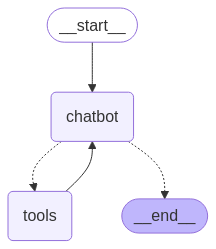

In [82]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [83]:
config = {"configurable": {"thread_id": "2"}}

In [84]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [85]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)

In [86]:
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Wr5HrTUpycOK2vrUkRauBDN9)
 Call ID: call_Wr5HrTUpycOK2vrUkRauBDN9
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "langgraph - PyPI", "url": "https://pypi.org/project/langgraph/", "content": "langgraph · PyPI\nSkip to main content Switch to mobile version\n\nSearch PyPI  Search\n\nHelp\nSponsors\nLog in\nRegister\n\nMenu\n\nHelp\nSponsors\nLog in\nRegister\n\nSearch PyPI  Search\nlanggraph 0.2.70\npip install langgraph Copy PIP instructions\nLatest versionReleased: Feb 6, 2025\nBuilding stateful, multi-actor applications with LLMs\nNavigation\n\nProje

In [87]:
# here is where we are updating the state with the human response
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_3eqQpAeEQSdi2e6ZfFgNMp4Z)
 Call ID: call_3eqQpAeEQSdi2e6ZfFgNMp4Z
  Args:
    name: LangGraph
    birthday: February 6, 2025
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was released on January 17, 2024.


In [ ]:
# we are getting the final state of the graph
snapshot = graph.get_state(config)
snapshot.values

{'messages': [HumanMessage(content='Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.', additional_kwargs={}, response_metadata={}, id='2bd389ef-6974-4a45-b099-76150224cb8a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Wr5HrTUpycOK2vrUkRauBDN9', 'function': {'arguments': '{"query":"LangGraph release date"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 134, 'total_tokens': 156, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'

In [93]:
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

Manually updating state

In [94]:
graph.update_state(config, {"name": "LangGraph (library)"})

snapshot = graph.get_state(config)
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

##### Part 6: Time Travel
if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy

In [95]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm_model.bind_tools(tools, parallel_tool_calls=False)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [96]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ZNvN31IcwCFDWUv6eeevVTaz)
 Call ID: call_ZNvN31IcwCFDWUv6eeevVTaz
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its

In [97]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya this one is  helpful. Maybe I'll "
                    "build an autonomous agent with it Help me with that!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya this one is  helpful. Maybe I'll build an autonomous agent with it Help me with that!
================================== Ai Message ==================================

Sure! Building an autonomous agent with LangGraph involves several steps. Here’s a high-level overview of the process:

### Step 1: Install LangGraph
First, you need to install LangGraph. You can do this using pip:
```bash
pip install langgraph
```

### Step 2: Define Your Workflow
LangGraph uses directed graphs to define workflows. You need to create nodes (actions) and edges (transitions) for your agent.

### Step 3: Create Nodes
Nodes represent actions that your agent can take. These can be function calls, API requests, or any other operations.

### Step 4: Define Edges
Edges define the sequence of actions. They connect nodes and specify the conditions under which transitions occur.

### Step 5: Implement the Agent
Combine the nodes a

In [ ]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [100]:
to_replay.values

{'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='d549f02c-8d22-4673-8802-01ac1ca569a7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZNvN31IcwCFDWUv6eeevVTaz', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 94, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_65792305e4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered'

In [103]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0156e0-dd21-6c10-8006-0fe5529cc332'}}


Notice that checkpoints are saved for every step of the graph. This spans invocations so you can rewind across a full thread's history. We've picked out to_replay as a state to resume from. This is the state after the chatbot node in the second graph invocation above.

In [ ]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.(Just load it from the checkpointer)
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Sure! Building an autonomous agent with LangGraph involves several steps. Here’s a high-level overview of the process:

### Step 1: Install LangGraph
First, you need to install LangGraph. You can do this using pip:
```bash
pip install langgraph
```

### Step 2: Define Your Workflow
LangGraph uses directed graphs to define workflows. You need to create nodes (actions) and edges (transitions) for your agent.

### Step 3: Create Nodes
Nodes represent actions that your agent can take. These can be function calls, API requests, or any other operations.

### Step 4: Define Edges
Edges define the sequence of actions. They connect nodes and specify the conditions under which transitions occur.

### Step 5: Implement the Agent
Combine the nodes and edges to create a complete workflow for your agent.

### Example: Building a Simple Autonomous Agent
Here’s a simple example to get you started:

```python
from langgra

############################################################################# END #############################################################################